In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from sklearn.metrics import mean_squared_error


In [29]:
data = pd.read_excel("IMPORTACION-VOLUMEN-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

import_data = data['Gasolina regular'].to_frame()
import_data

,Gasolina regular
Fecha,
2001-01-01 00:00:00,177776.50
2001-02-01 00:00:00,123115.99
2001-03-01 00:00:00,161726.42
2001-04-01 00:00:00,127338.74
2001-05-01 00:00:00,168730.19
...,...
2024-01-01 00:00:00,914133.32
2024-02-01 00:00:00,740662.25
2024-03-01 00:00:00,838270.93


In [30]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(import_data.index, pd.DatetimeIndex):
    import_data.index = pd.to_datetime(import_data.index)

# Group the data by year and sum the values
import_data_yearly = import_data.resample('Y').sum()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_21721/2232612997.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  import_data_yearly = import_data.resample('Y').sum()


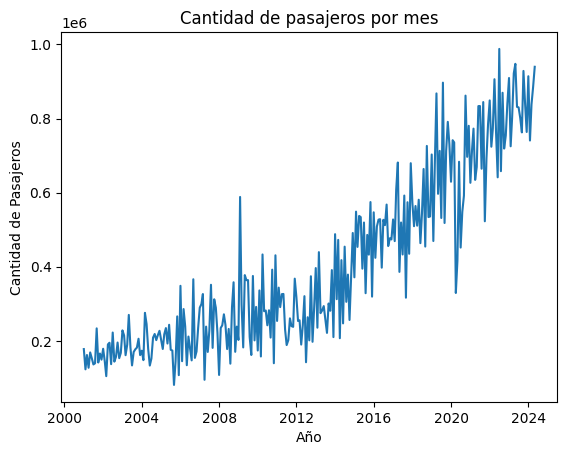

In [31]:
plt.plot(import_data)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

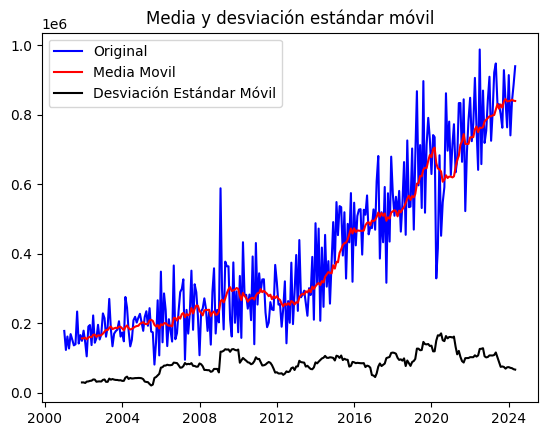

In [32]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = import_data.rolling(window=12).mean()
deMovil = import_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(import_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

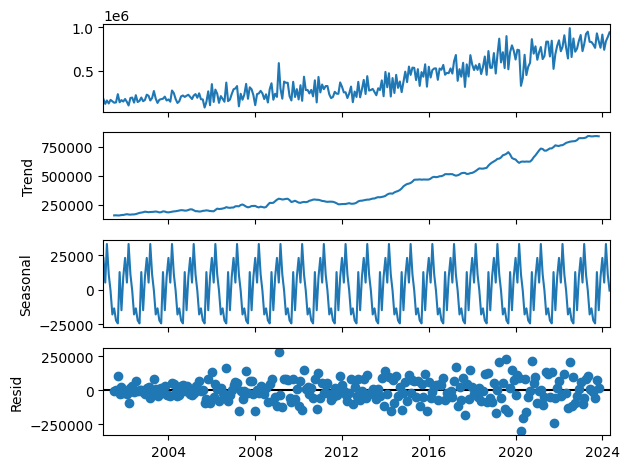

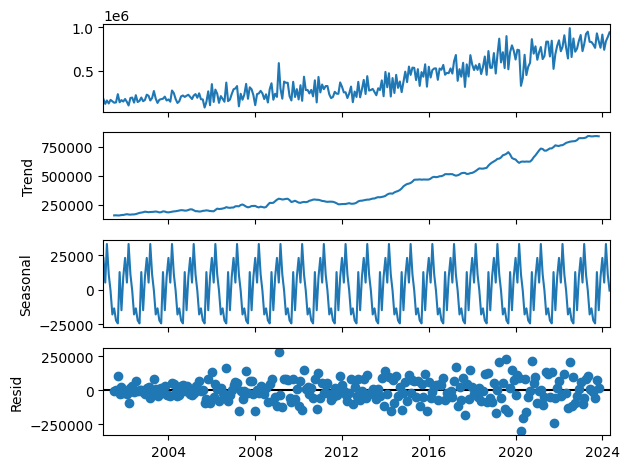

In [33]:
descomposicion = seasonal_decompose(import_data, model='additive', period=12)
descomposicion.plot()

In [34]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(import_data, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.828829
p-value                        0.992088
# de retardos usados           9.000000
# de observaciones usadas    271.000000
Critical Value (1%)           -3.454713
Critical Value (5%)           -2.872265
Critical Value (10%)          -2.572485
dtype: float64


In [35]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
import_data_diff = import_data.diff()
import_data_diff.fillna(0,inplace=True)
dfTest = adfuller(import_data_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.012772e+01
p-value                      9.088501e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.720000e+02
Critical Value (1%)         -3.454622e+00
Critical Value (5%)         -2.872225e+00
Critical Value (10%)        -2.572464e+00
dtype: float64


In [36]:
scaler = StandardScaler()
import_data_scaled = scaler.fit_transform(import_data_diff) 
import_data_scaled[1:7]


array([[-0.4269126 ],
       [ 0.26713085],
       [-0.27605935],
       [ 0.28782485],
       [-0.13797697],
       [-0.14369818]])

In [37]:
entrenamiento = round(0.6*len(import_data_scaled))
val_prueba = round(0.2*len(import_data_scaled))
test = import_data_scaled[(entrenamiento+val_prueba)-1:]
validation = import_data_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = import_data_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

57

In [38]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [39]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

In [40]:
modelo1 = Sequential()
loteModelo1 = 1
unidades =  1
pasoModelo1 = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((pasoModelo1, caracteristicas))
lstm_out = keras.layers.LSTM(loteModelo1)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
modelo2 = Sequential()
lote = 1
unidades = 1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(10)(lstm_out)

modelo2 = keras.Model(inputs=inputs, outputs=outputs)
modelo2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 2)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70 (280.00 B)

 Trainable params: 70 (280.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [42]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

history2= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3682 - val_loss: 1.4020
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.3610 - val_loss: 1.3713
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.3535 - val_loss: 1.3385
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.3456 - val_loss: 1.3045
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.3376 - val_loss: 1.2700
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 0.3297 - val_loss: 1.2354
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.3220 - val_loss: 1.2015
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 0.3148 - val_loss: 1.1686
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.3082 - val_loss: 1.1370
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.3023 - val_loss: 1.1072
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.2970 - val_loss: 1.0793
Epoch 12/50
169/169 ━━━━━━━━━━━━

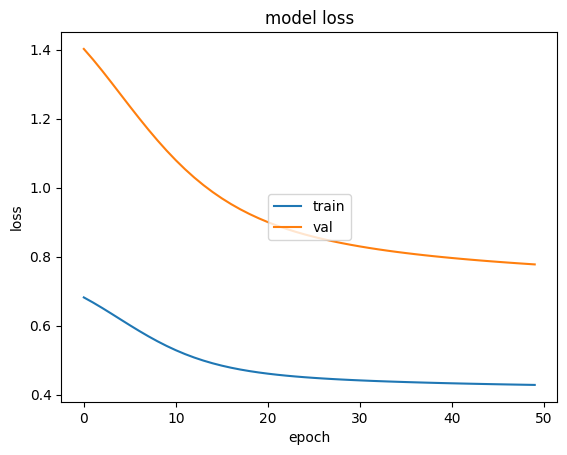

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [44]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.3291
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6934 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1689 


1.1036626100540161

In [46]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
            # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = import_data.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = import_data.values , n=entrenamiento+val_prueba)


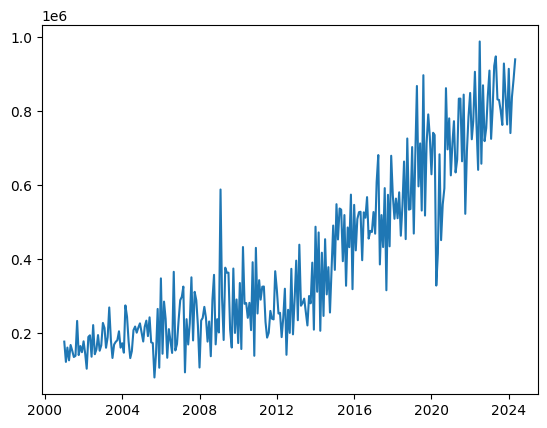

In [49]:
plt.plot(import_data)

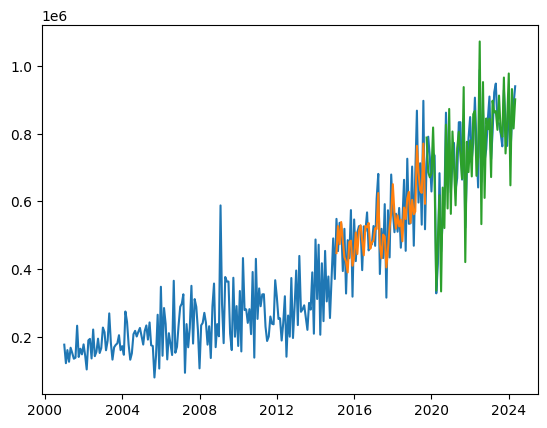

In [48]:
df_val = pd.DataFrame(prediccion_val,index=import_data[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=import_data[entrenamiento+len(df_val):len(import_data)].index)


plt.plot(import_data)
plt.plot(df_val)
plt.plot(df_test)